# Models

In [66]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

In [67]:
# load pre porcessed data
df = pd.read_csv('../../prepross_data/data.csv')


#### Filterout the paper described patient set

In [68]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] >= diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)


Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7156


In [69]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)

### for SH events prediction pre processing


In [70]:
y_label = 'SHSeizComaPast12mos' 



In [71]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)

In [72]:
df['Pt_SmokeAmt'] = df['Pt_SmokeAmt'].replace({
    0: 0,1:0, 2:0, 3:0, 5:0, 6:0,
    4: 1
})

In [73]:
# Pt_SmokeAmt {'1 pack': 0, '2 - 3 packs': 1, '4 - 5 packs': 2, '6 - 7 packs': 3, "Don't smoke at all anymore": 4, 'Less than 1 pack': 5, 'more than 7 packs': 6}
df['Pt_SmokeAmt'].mode()

0    1.0
dtype: float64

In [74]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val

# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [75]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_EduLevel', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'R

In [76]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,AtrialFib,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872


In [77]:
df['Pt_SmokeAmt']

0        NaN
4        1.0
7        1.0
14       1.0
15       NaN
        ... 
25736    NaN
25738    0.0
25748    NaN
25757    1.0
25758    NaN
Name: Pt_SmokeAmt, Length: 6656, dtype: float64

# Divide Dataset

In [78]:
df = df[['AgeAtConsent','diagDuration','HbA1c','Gender','Pt_RaceEth',
         'Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel','bmi',
         'Pt_NumBolusDay',
         'Pt_InsulinRecMethod',
#          'InsulinDeliv', 
         'Pt_SmokeAmt',
             'relative_T1D',y_label
            ]]


In [79]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


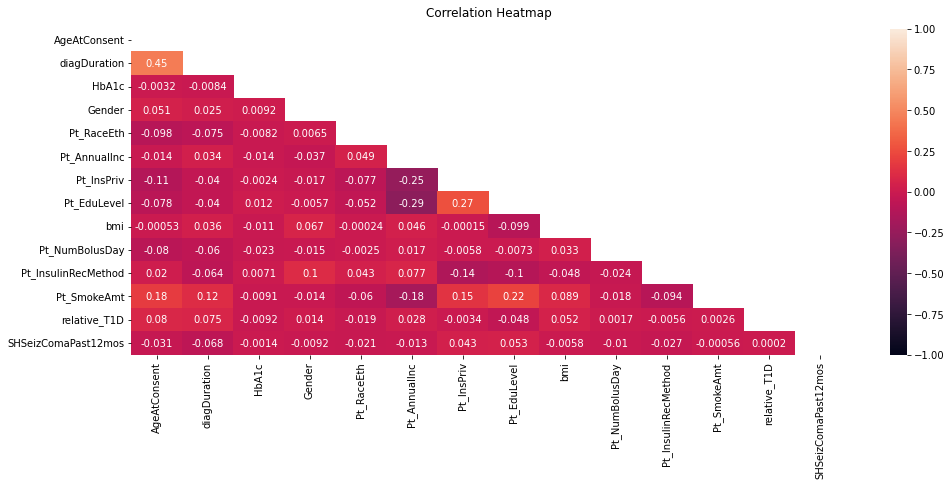

In [80]:

# df.drop(['Lipoatrophy',
#  'AgeAtConsent',
#  'InsCarbRatDinn',
#  'InsNovolog',
#  'CGMGlucPctBelow60'], inplace=True, axis=1)
# df.head(10)
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')


In [81]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [82]:
Y.unique()

array([1., 0.])

# Feature Selection

In [83]:
shape = np.shape(X) 
feature = shape[1] 
n_classes = 2


In [84]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


In [85]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 154 4838]
Test -  [0. 1.] [  51 1613]


# Imputations

<AxesSubplot:>

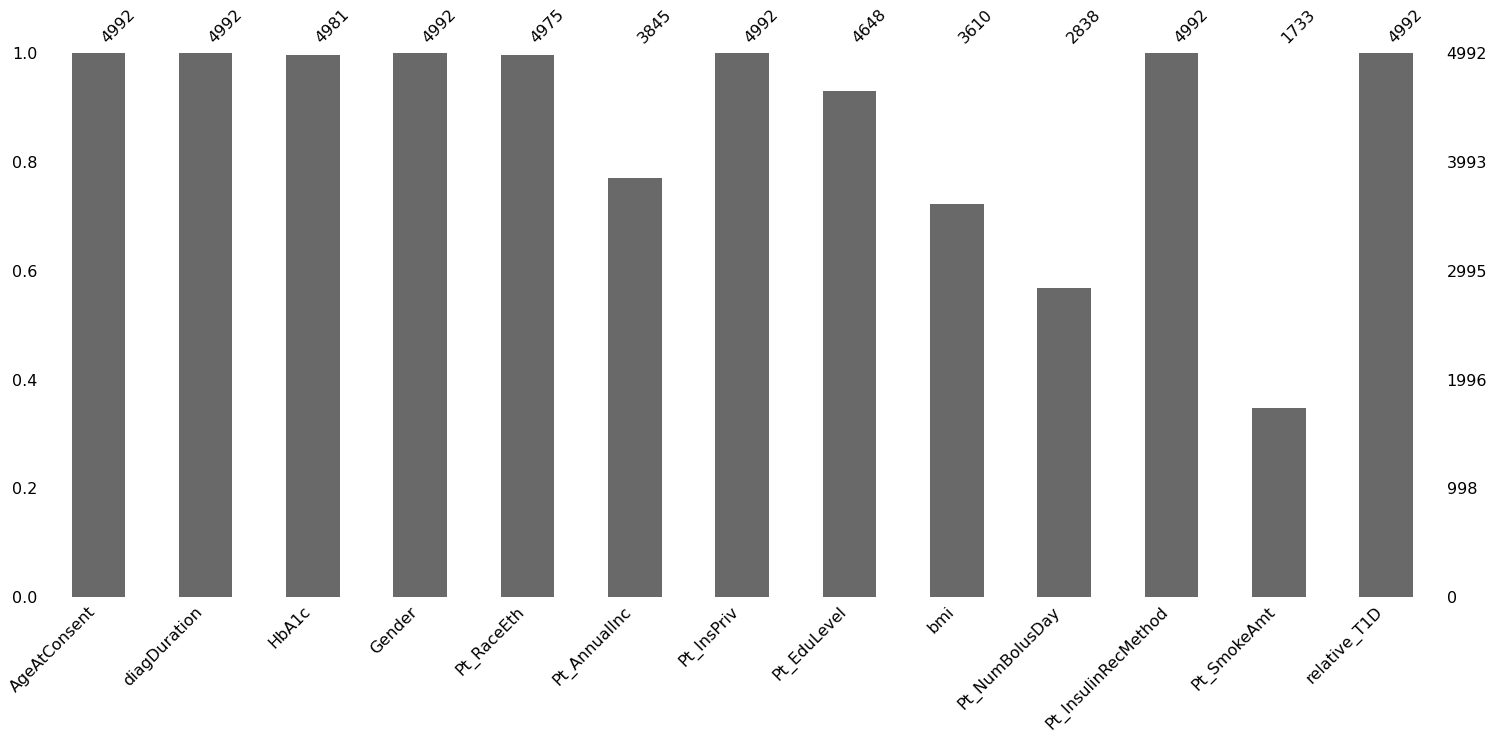

In [86]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [87]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [88]:
# use only for XGB classifier with missing values
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


In [89]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values

from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()

def cross_val_with_missing_val(model,n_splits=5):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



Accuracy for the fold no. 1 on the test set: 0.968968968968969, doublecheck: 0.968968968968969
Accuracy for the fold no. 2 on the test set: 0.968968968968969, doublecheck: 0.968968968968969
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.968937875751503, doublecheck: 0.968937875751503
Accuracy for the fold no. 5 on the test set: 0.968937875751503, doublecheck: 0.968937875751503
Cross validation mean accuracy 0.9691507138400925

 
 ===========   Train Dataset    =============
train ROC score 0.9028577871074771
Threshold value is: 0.9551555306916305


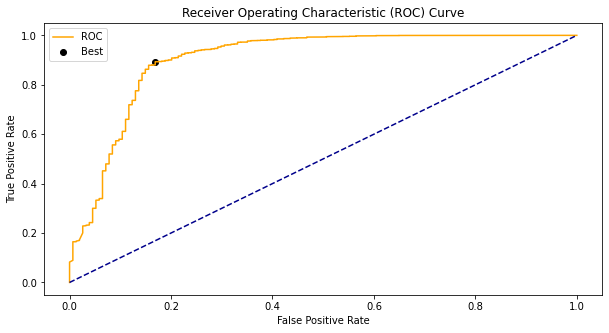

accuracy score:  89.12259615384616
              precision    recall  f1-score   support

         0.0       0.20      0.83      0.32       154
         1.0       0.99      0.89      0.94      4838

    accuracy                           0.89      4992
   macro avg       0.60      0.86      0.63      4992
weighted avg       0.97      0.89      0.92      4992



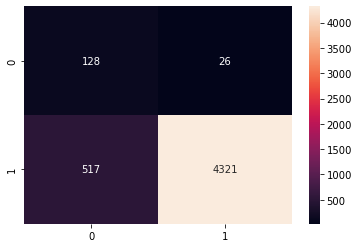

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9723632622015688


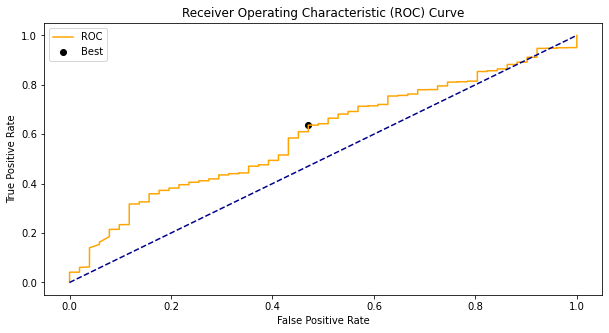

accuracy score:  63.34134615384615
              precision    recall  f1-score   support

         0.0       0.04      0.53      0.08        51
         1.0       0.98      0.64      0.77      1613

    accuracy                           0.63      1664
   macro avg       0.51      0.58      0.43      1664
weighted avg       0.95      0.63      0.75      1664



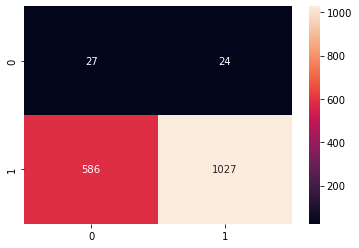

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.5945


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.52941176 0.6367018 ]
average accuracy:  0.5830567812990044


In [90]:
# HistGradientBoostingClassifier - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 100,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)



Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Cross validation mean accuracy 0.9691511022044088

 
 ===========   Train Dataset    ========

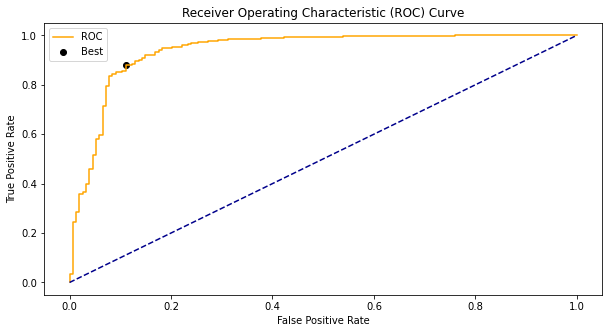

accuracy score:  88.06089743589743
              precision    recall  f1-score   support

         0.0       0.19      0.89      0.31       154
         1.0       1.00      0.88      0.93      4838

    accuracy                           0.88      4992
   macro avg       0.59      0.88      0.62      4992
weighted avg       0.97      0.88      0.92      4992



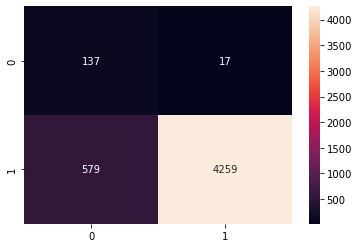

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 2.3814697


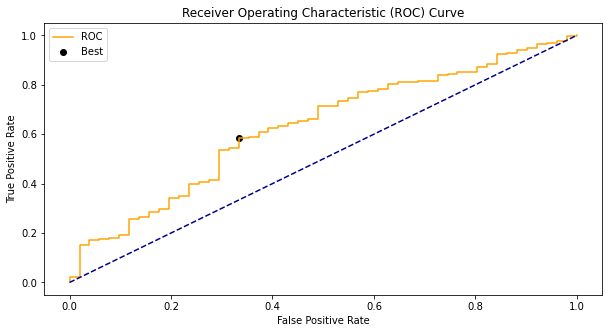

accuracy score:  58.65384615384615
              precision    recall  f1-score   support

         0.0       0.05      0.67      0.09        51
         1.0       0.98      0.58      0.73      1613

    accuracy                           0.59      1664
   macro avg       0.52      0.63      0.41      1664
weighted avg       0.95      0.59      0.71      1664



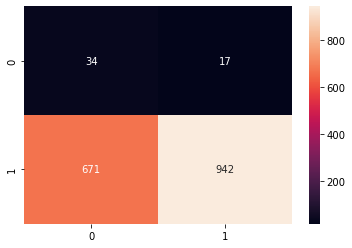

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6286


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.66666667 0.58400496]
average accuracy:  0.6253358131845422
f1 0.7325038880248833


In [26]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
        n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
#         objective = 'binary:logistic', 
        objective='multi:softmax',
        min_child_weight = 4,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))


<AxesSubplot:>

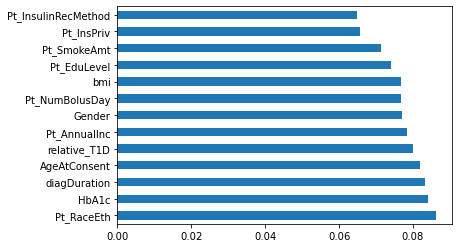

In [27]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Cross validation mean accuracy 0.9691511022044088

 
 ===========   Train Dataset    ========

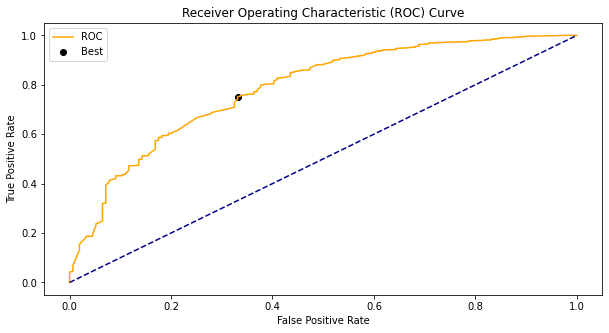

accuracy score:  74.8798076923077
              precision    recall  f1-score   support

         0.0       0.08      0.67      0.14       154
         1.0       0.99      0.75      0.85      4838

    accuracy                           0.75      4992
   macro avg       0.53      0.71      0.50      4992
weighted avg       0.96      0.75      0.83      4992



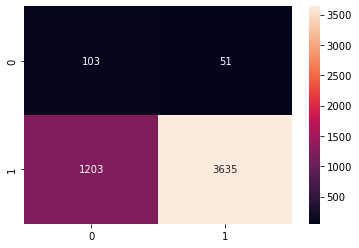

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9703041102360632


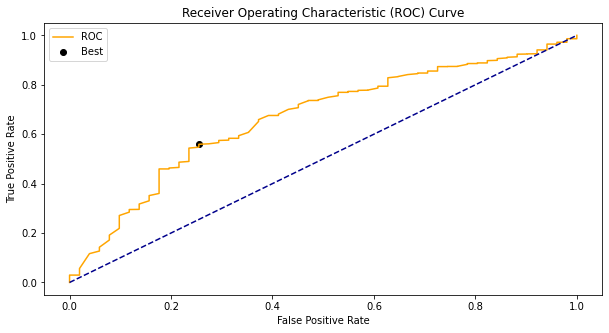

accuracy score:  56.49038461538461
              precision    recall  f1-score   support

         0.0       0.05      0.75      0.10        51
         1.0       0.99      0.56      0.71      1613

    accuracy                           0.56      1664
   macro avg       0.52      0.65      0.40      1664
weighted avg       0.96      0.56      0.69      1664



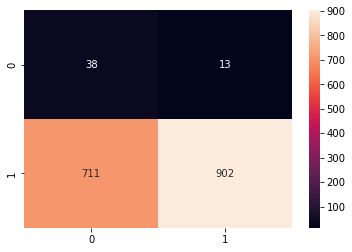



 ===========   ROC    =============
roc_auc = 0.666


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.74509804 0.55920645]
average accuracy:  0.6521522434144147
f1 0.7136075949367089


In [91]:

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.01, 
#                          scale_pos_weight=6,
                         max_depth =3, random_state=0 )

                
                
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
# optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# test_acc = model.score(X_test_copy, Y_test)
# print('Accuracy of XGB classifier on test set: {:.2f}'
#      .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

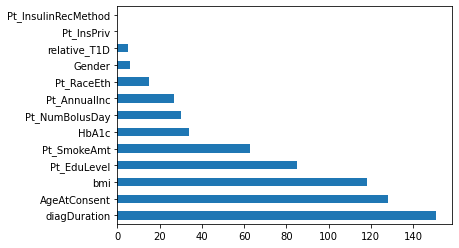

In [92]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


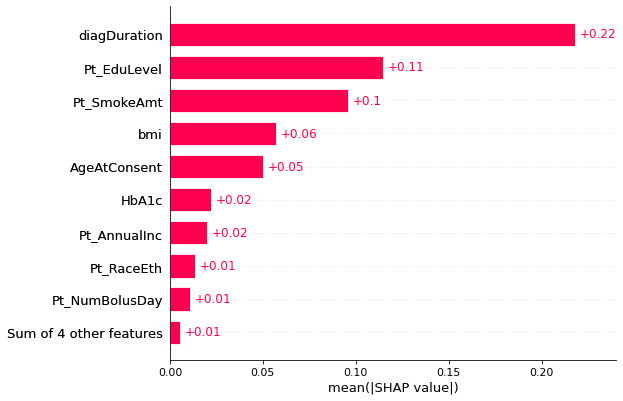

<Figure size 432x288 with 0 Axes>

In [104]:
explainer = shap.TreeExplainer(model, X_train_copy)
shap_values = explainer(X_train_copy)
shap.plots.bar(shap_values)
plt.savefig('fiSHbaseline.png')

In [34]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')


imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)

In [35]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)


# Scale data

In [36]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [37]:
#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])

    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [38]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[04:26:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



Index(['AgeAtConsent', 'diagDuration', 'HbA1c', 'Gender', 'Pt_RaceEth',
       'Pt_AnnualInc', 'Pt_InsPriv', 'Pt_EduLevel', 'bmi', 'Pt_NumBolusDay',
       'Pt_InsulinRecMethod', 'Pt_SmokeAmt', 'relative_T1D'],
      dtype='object')
(6656, 13)


In [40]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


### Common functions

In [41]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):

    dfs = []
    acc_arr = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")
        acc_arr.append(accuracy_score(y_test1, model.predict(X_test1)))
        
        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    print("Cross validation mean accuracy" , sum(acc_arr) / len(acc_arr))
    return model



In [42]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
    optimal_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
#     optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    plt.show()
    return optimal_threshold

In [51]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test, average='micro'))    

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Cross validation mean accuracy 0.9691511022044088
Train ROC
0.8270697884174526
Threshold valu

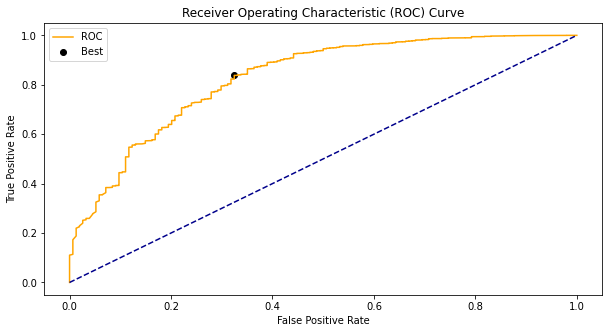

Test ROC
0.6061655908488629
Threshold value is: 0.9708122205876295


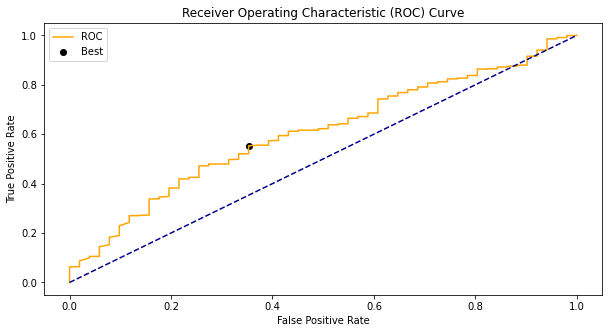


 
 =====================   Train Dataset    ======================
83.29326923076923
              precision    recall  f1-score   support

         0.0       0.12      0.68      0.20       154
         1.0       0.99      0.84      0.91      4838

    accuracy                           0.83      4992
   macro avg       0.55      0.76      0.55      4992
weighted avg       0.96      0.83      0.88      4992



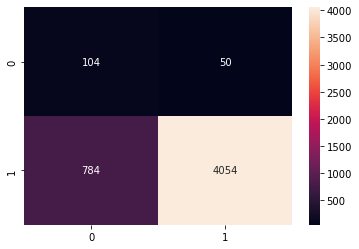

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
55.588942307692314
              precision    recall  f1-score   support

         0.0       0.04      0.65      0.08        51
         1.0       0.98      0.55      0.71      1613

    accuracy                           0.56      1664
   macro avg       0.51      0.60      0.39      1664
weighted avg       0.95      0.56      0.69      1664



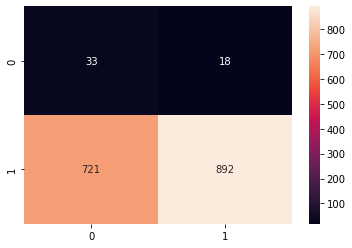

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6062


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.64705882 0.55300682]
average accuracy:  0.6000328215601182
f1 0.5558894230769231


In [52]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.01, 
                         max_depth =4, random_state=0 )
# adaboost.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

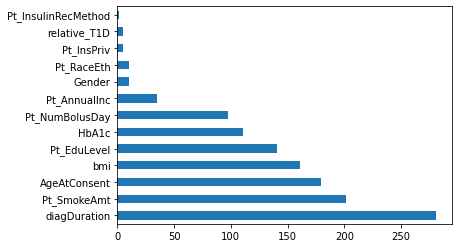

In [45]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [46]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.SHSeizComaPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    plt.axhline(y=thresh1, color = 'r')
    plt.axhline(y=thresh2, color = 'g')
    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()

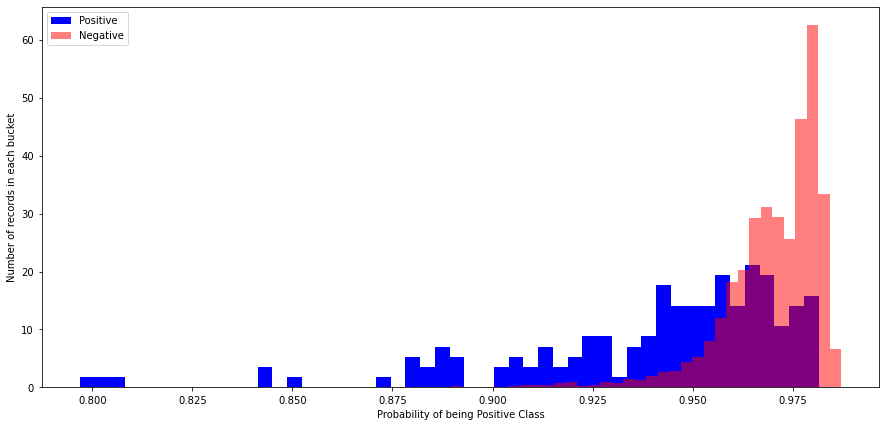

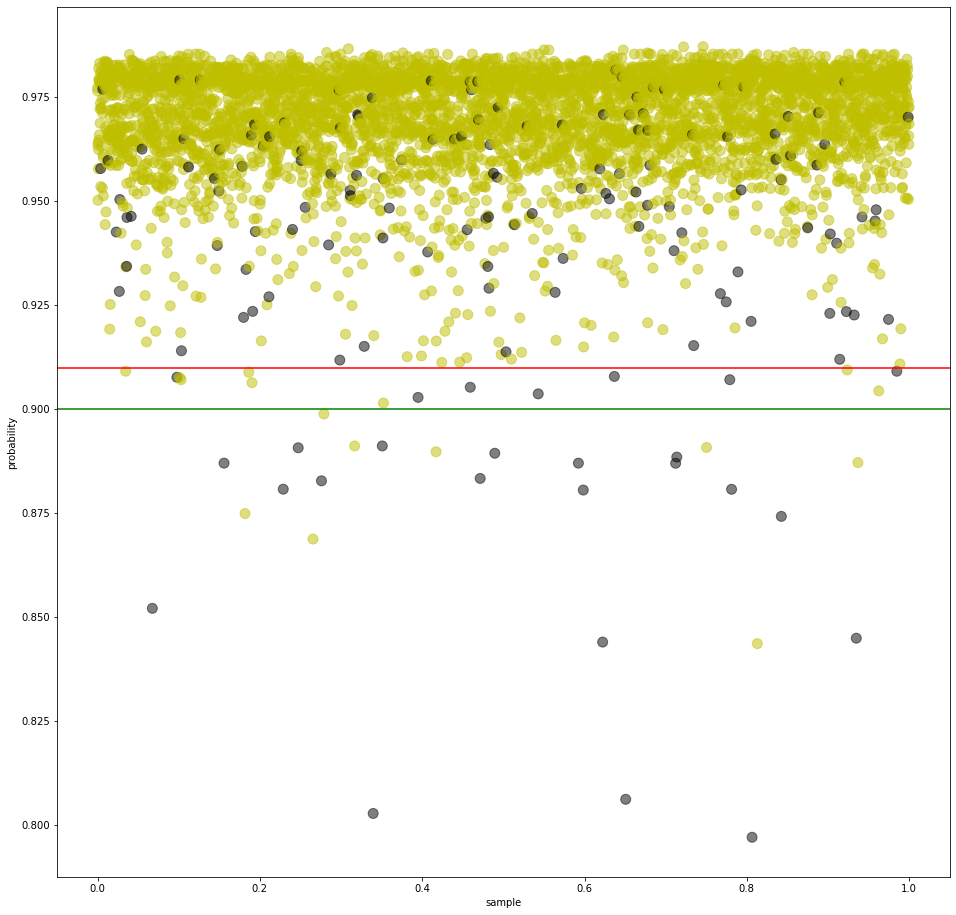

In [47]:
patients_count = X_train.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.85
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction) # sort decreasong order
        threshold = np.round(prediction[no_patients-1],2)

    return threshold
    
thresh1 = get_optimal_threshold(ltb_model, X_train, 8000, 200)
thresh2 = 0.9
draw_boundary(ltb_model, X_train, Y_train, thresh1, thresh2)

In [48]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [49]:

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (ltb_model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
ltb_model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(ltb_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

predictoin [1]
actial 1.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [50]:
# compute SHAP values
explainer = shap.Explainer(ltb_model, X_train)
shap_values = explainer(X_train)

import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, show=False)
shap.plots.beeswarm(shap_values[-1:], show=False, color="black")
pl.show()

Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 3.756984, while the model output was 3.692598. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
pred = ltb_model.predict_proba(X_train)[:,1] 
Y_train = pd.DataFrame(Y_train)
X_beeswarm = X_train.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y_train
X_beeswarm['Y'] = Y_train[y_label].to_list()

In [ ]:
idx = np.where((X_beeswarm['pred']>thresh2) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0.85) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative case in positive side
idx3 = np.where((X_beeswarm['pred']<0.85) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(ltb_model, X_beeswarm)
shap_values = explainer(X_beeswarm)



In [ ]:

shap.plots.beeswarm(shap_values, show=False, plot_size=[15,15], alpha = 1)
shap.plots.beeswarm(shap_values[402:403:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[760:761:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[840:841:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1243:1244:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1395:1396:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1558:1559:], show=False, color="black", plot_size=[15,15])


shap.plots.beeswarm(shap_values[179:180:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[192:193:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[334:335:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[348:349:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[413:414:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[425:426:], show=False, color="yellow", plot_size=[15,15])

shap.plots.beeswarm(shap_values[1427:1428:], show=False, color="green", plot_size=[15,15])
shap.plots.beeswarm(shap_values[2212:2213:], show=False, color="green", plot_size=[15,15])


plt.show()


### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Cross validation mean accuracy 0.9691511022044088
Train ROC
0.7263546705464854
Threshold valu

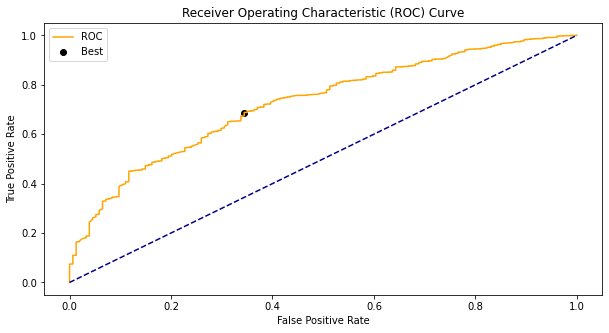

Test ROC
0.5759636774734692
Threshold value is: 0.6102611103471763


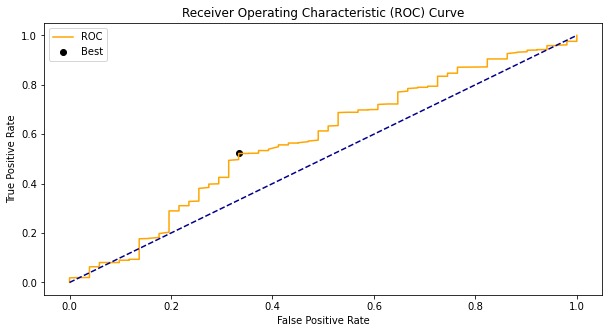


 
 =====================   Train Dataset    ======================
68.6698717948718
              precision    recall  f1-score   support

         0.0       0.06      0.66      0.11       154
         1.0       0.98      0.69      0.81      4838

    accuracy                           0.69      4992
   macro avg       0.52      0.67      0.46      4992
weighted avg       0.96      0.69      0.79      4992



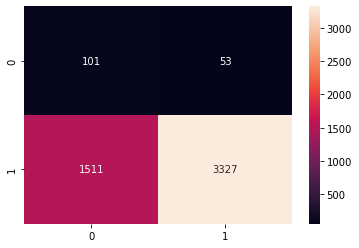

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
52.644230769230774
              precision    recall  f1-score   support

         0.0       0.04      0.67      0.08        51
         1.0       0.98      0.52      0.68      1613

    accuracy                           0.53      1664
   macro avg       0.51      0.59      0.38      1664
weighted avg       0.95      0.53      0.66      1664



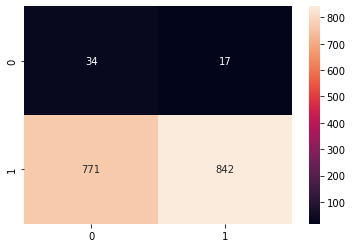

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.576


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.66666667 0.52200868]
average accuracy:  0.5943376730729489
f1 0.5264423076923077


In [53]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.008,
                              n_estimators=1000,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

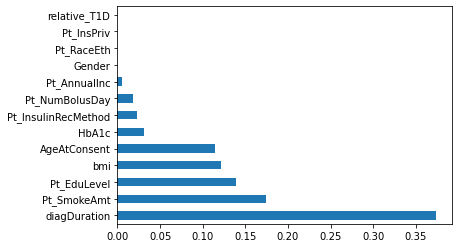

In [54]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.966, doublecheck: 0.966
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Cross validation mean accuracy 0.9689511022044087
Train ROC
0.9618147458163995
Threshold valu

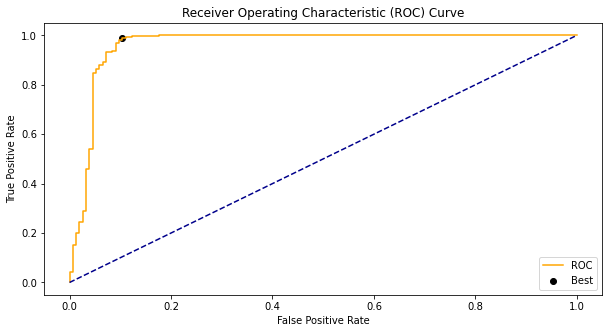

Test ROC
0.5844790489041246
Threshold value is: 2.5773242


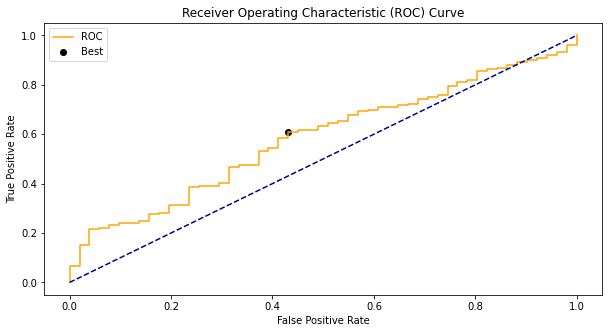


 
 =====================   Train Dataset    ======================
98.59775641025641
              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80       154
         1.0       1.00      0.99      0.99      4838

    accuracy                           0.99      4992
   macro avg       0.86      0.94      0.90      4992
weighted avg       0.99      0.99      0.99      4992



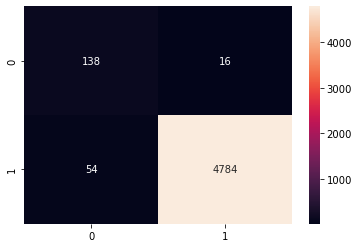

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
60.87740384615385
              precision    recall  f1-score   support

         0.0       0.04      0.57      0.08        51
         1.0       0.98      0.61      0.75      1613

    accuracy                           0.61      1664
   macro avg       0.51      0.59      0.42      1664
weighted avg       0.95      0.61      0.73      1664



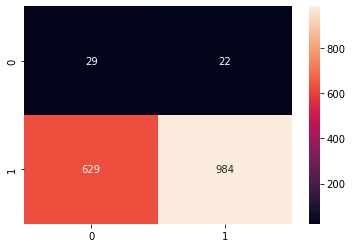

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.5845


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.56862745 0.6100434 ]
average accuracy:  0.5893354241882742
f1 0.6087740384615384


In [55]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 6, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

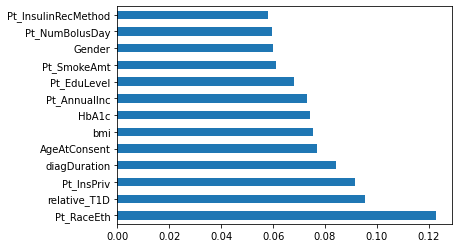

In [56]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.772, doublecheck: 0.772
Accuracy for the fold no. 2 on the test set: 0.72, doublecheck: 0.72
Accuracy for the fold no. 3 on the test set: 0.7935871743486974, doublecheck: 0.7935871743486974
Accuracy for the fold no. 4 on the test set: 0.8356713426853707, doublecheck: 0.8356713426853707
Accuracy for the fold no. 5 on the test set: 0.7755511022044088, doublecheck: 0.7755511022044088
Accuracy for the fold no. 6 on the test set: 0.7434869739478958, doublecheck: 0.7434869739478958
Accuracy for the fold no. 7 on the test set: 0.8096192384769539, doublecheck: 0.8096192384769539
Accuracy for the fold no. 8 on the test set: 0.7454909819639278, doublecheck: 0.7454909819639278
Accuracy for the fold no. 9 on the test set: 0.8216432865731463, doublecheck: 0.8216432865731463
Accuracy for the fold no. 10 on the test set: 0.7595190380761523, doublecheck: 0.7595190380761523
Cross validation mean accuracy 0.7776569138276553
Train ROC
0.7755881468676012
Thre

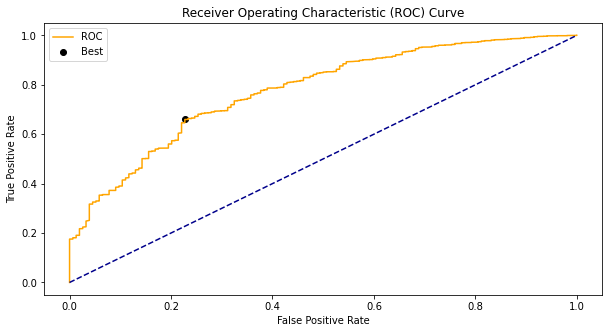

Test ROC
0.6101588806632388
Threshold value is: 0.5803387072437081


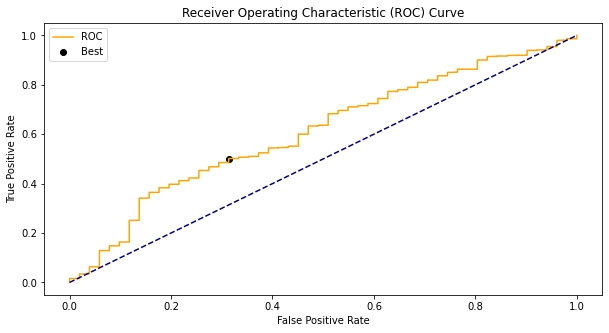


 
 =====================   Train Dataset    ======================
66.30608974358975
              precision    recall  f1-score   support

         0.0       0.07      0.77      0.12       154
         1.0       0.99      0.66      0.79      4838

    accuracy                           0.66      4992
   macro avg       0.53      0.72      0.46      4992
weighted avg       0.96      0.66      0.77      4992



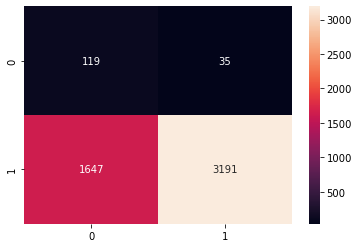

Accuracy of on training set: 0.77


 =====================   Test Dataset    =======================
50.72115384615385
              precision    recall  f1-score   support

         0.0       0.04      0.69      0.08        51
         1.0       0.98      0.50      0.66      1613

    accuracy                           0.51      1664
   macro avg       0.51      0.59      0.37      1664
weighted avg       0.95      0.51      0.65      1664



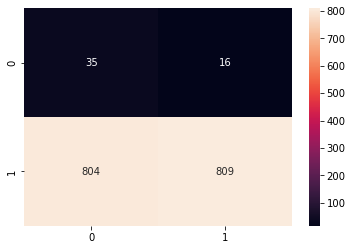

Accuracy of classifier on test set: 0.74


 =======================   Test-ROC    =========================
roc_auc = 0.6102


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.68627451 0.50154991]
average accuracy:  0.5939122084047506
f1 0.5072115384615384


In [57]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=5,
                             n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

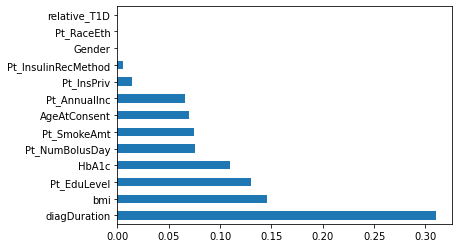

In [58]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

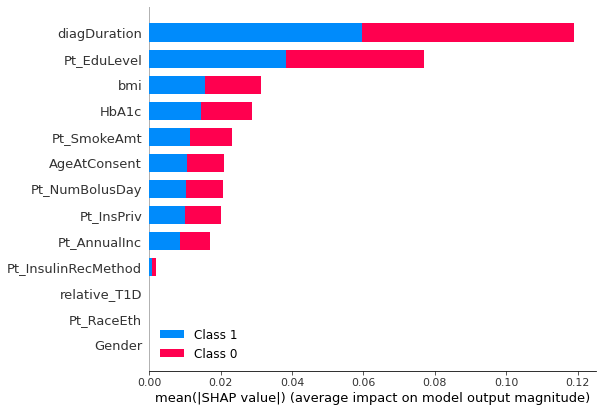

In [59]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.606, doublecheck: 0.606
Accuracy for the fold no. 2 on the test set: 0.614, doublecheck: 0.614
Accuracy for the fold no. 3 on the test set: 0.591182364729459, doublecheck: 0.591182364729459


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 4 on the test set: 0.6513026052104208, doublecheck: 0.6513026052104208


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.6352705410821643, doublecheck: 0.6352705410821643


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 6 on the test set: 0.5991983967935872, doublecheck: 0.5991983967935872
Accuracy for the fold no. 7 on the test set: 0.6052104208416834, doublecheck: 0.6052104208416834
Accuracy for the fold no. 8 on the test set: 0.6332665330661322, doublecheck: 0.6332665330661322


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


Accuracy for the fold no. 9 on the test set: 0.627254509018036, doublecheck: 0.627254509018036
Accuracy for the fold no. 10 on the test set: 0.4308617234468938, doublecheck: 0.4308617234468938
Cross validation mean accuracy 0.5993547094188377
Train ROC
0.570703789802591
Threshold value is: 0.429552899822387


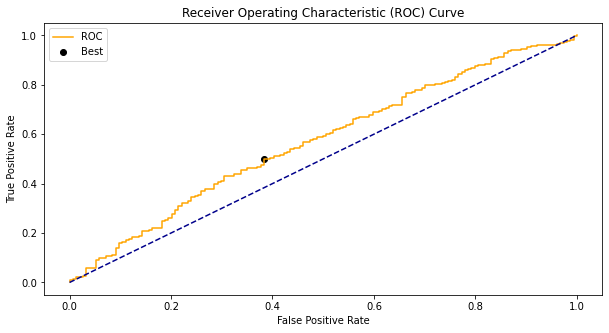

Test ROC
0.5944713905400969
Threshold value is: 0.43358580003016683


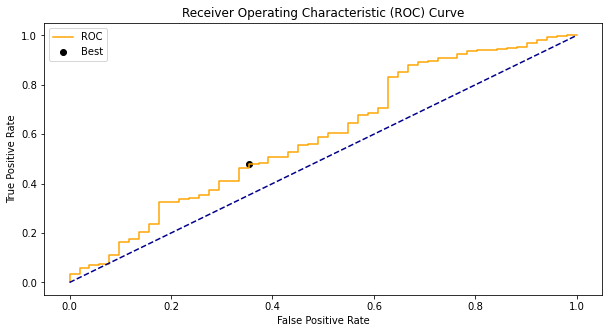


 
 =====================   Train Dataset    ======================
50.16025641025641
              precision    recall  f1-score   support

         0.0       0.04      0.62      0.07       154
         1.0       0.98      0.50      0.66      4838

    accuracy                           0.50      4992
   macro avg       0.51      0.56      0.37      4992
weighted avg       0.95      0.50      0.64      4992



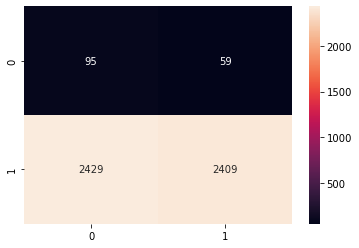

Accuracy of on training set: 0.40


 =====================   Test Dataset    =======================
48.31730769230769
              precision    recall  f1-score   support

         0.0       0.04      0.65      0.07        51
         1.0       0.98      0.48      0.64      1613

    accuracy                           0.48      1664
   macro avg       0.51      0.56      0.36      1664
weighted avg       0.95      0.48      0.62      1664



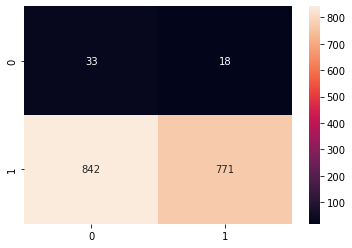

Accuracy of classifier on test set: 0.38


 =======================   Test-ROC    =========================
roc_auc = 0.5945


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.64705882 0.47799132]
average accuracy:  0.5625250720250903
f1 0.4831730769230769


In [60]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

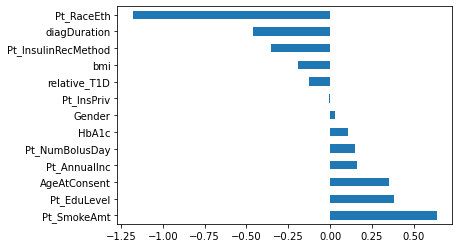

In [61]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Cross validation mean accuracy 0.9691511022044088
Train ROC
0.6374199384740931
Threshold valu

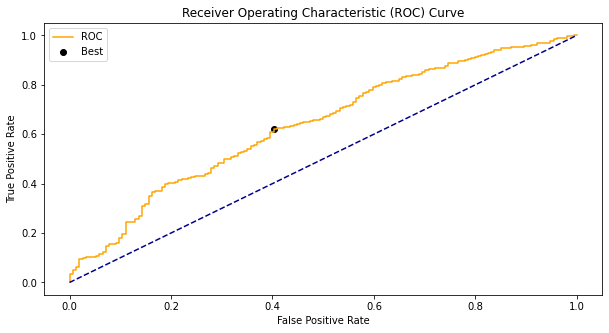

Test ROC
0.6341246976161822
Threshold value is: 0.9719183988483042


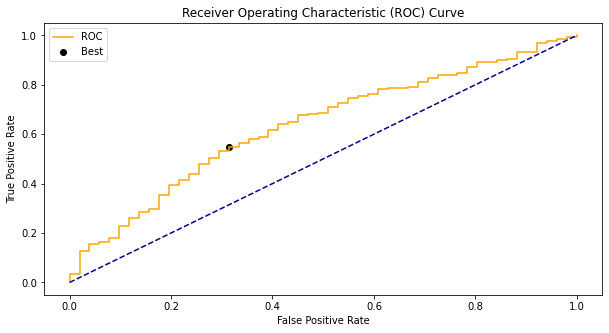


 
 =====================   Train Dataset    ======================
62.13942307692307
              precision    recall  f1-score   support

         0.0       0.05      0.60      0.09       154
         1.0       0.98      0.62      0.76      4838

    accuracy                           0.62      4992
   macro avg       0.51      0.61      0.42      4992
weighted avg       0.95      0.62      0.74      4992



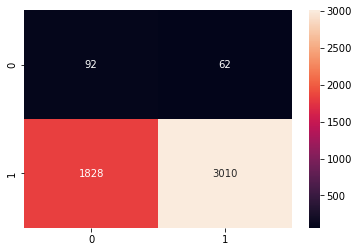

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
55.40865384615385
              precision    recall  f1-score   support

         0.0       0.05      0.69      0.09        51
         1.0       0.98      0.55      0.71      1613

    accuracy                           0.55      1664
   macro avg       0.51      0.62      0.40      1664
weighted avg       0.95      0.55      0.69      1664



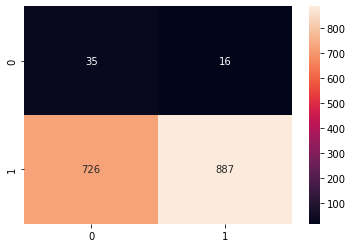

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6341


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.68627451 0.54990701]
average accuracy:  0.6180907576917933
f1 0.5540865384615384


In [62]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


<AxesSubplot:>

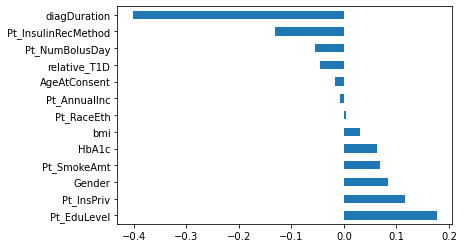

In [63]:


feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Cross validation mean accuracy 0.9691511022044088
Train ROC
0.6344885994534609
Threshold valu

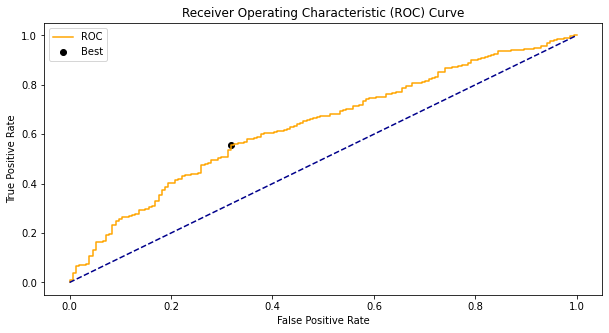

Test ROC
0.5551706113319476
Threshold value is: 0.9719352550252397


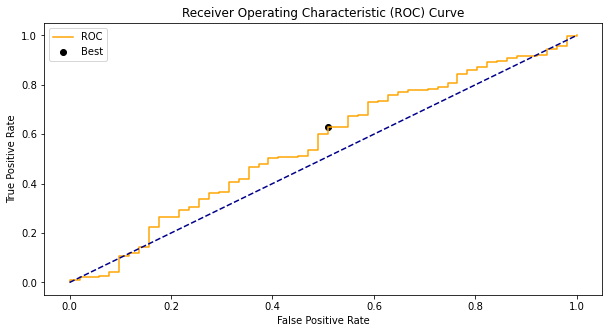


 
 =====================   Train Dataset    ======================
55.92948717948718
              precision    recall  f1-score   support

         0.0       0.05      0.68      0.09       154
         1.0       0.98      0.56      0.71      4838

    accuracy                           0.56      4992
   macro avg       0.51      0.62      0.40      4992
weighted avg       0.95      0.56      0.69      4992



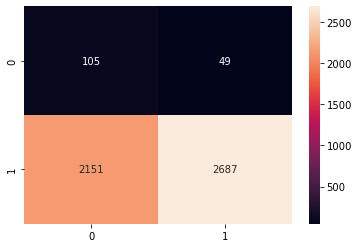

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
62.31971153846154
              precision    recall  f1-score   support

         0.0       0.04      0.49      0.07        51
         1.0       0.97      0.63      0.76      1613

    accuracy                           0.62      1664
   macro avg       0.51      0.56      0.42      1664
weighted avg       0.95      0.62      0.74      1664



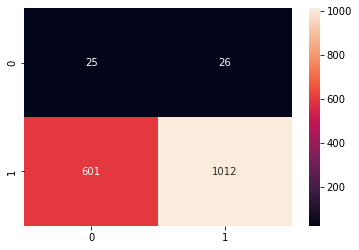

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.5552


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.49019608 0.62740236]
average accuracy:  0.5587992171450105
f1 0.6231971153846154


In [64]:
gnb = GaussianNB(priors=None, var_smoothing=1)
gnb = cross_val(gnb)
# gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


<AxesSubplot:>

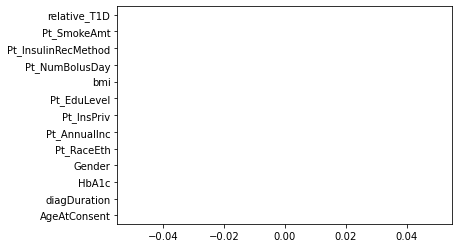

In [65]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')